## Organ differences by Milo - lymphoid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

import milopy.core as milo
import milopy.plot as milopl

In [3]:
## import project utils
cwd = '../utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

In [4]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/organ_milo_analysis_LYMPHOID/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
import milopy

def annotate_nhoods(adata, anno_col):
    anno_dummies = pd.get_dummies(adata.obs[anno_col])
    anno_count = adata.obsm["nhoods"].T.dot(scipy.sparse.csr_matrix(anno_dummies.values))
    anno_frac = np.array(anno_count/anno_count.sum(1))

    anno_frac = pd.DataFrame(anno_frac, 
                             columns=anno_dummies.columns,
                             index=adata.uns["nhood_adata"].obs_names
                            )
    adata.uns["nhood_adata"].obsm["frac_annotation"] = anno_frac.values
    adata.uns["nhood_adata"].uns["annotation_labels"] = anno_frac.columns
    adata.uns["nhood_adata"].obs["nhood_annotation"] = anno_frac.idxmax(1)
    adata.uns["nhood_adata"].obs["nhood_annotation_frac"] = anno_frac.max(1)

## Load milo neighbourhoods
Computed in `src/7_differential_abundance`

In [9]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="LYMPHOID"

In [10]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_outs/{s}/'.format(s=split)
adata = sc.read_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split))

In [11]:
nhood_adata = sc.read_h5ad(outdir + "milo_nhood_adata.{s}.h5ad".format(s=split))

adata.uns["nhood_adata"] = nhood_adata.copy()

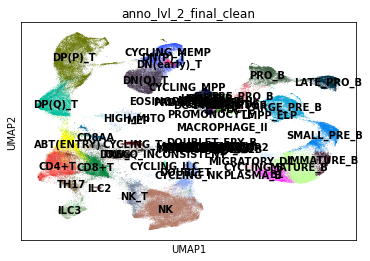

In [12]:
sc.pl.umap(adata, color='anno_lvl_2_final_clean', legend_loc='on data')

### Make neighbourhoods
Larger neighbourhoods than for analysis in time (more samples per condition)

In [13]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 100, key_added="scvi")

## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)

## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="Sample.lanes")

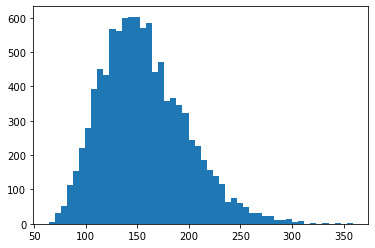

In [14]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=50);

### Test

In [22]:
adata.obs['organ'] = adata.obs['organ'].astype("category")
milopy.utils.add_covariate_to_nhoods_var(adata, ['method', 'Sort_id', 'donor', 'organ'])
adata.uns['nhood_adata'].var['organ'] = adata.uns['nhood_adata'].var['organ'].astype('category')
all_organs = adata.obs.organ.unique().tolist()
design = '~ method + correction_factor + organ'

## Calculate logFC and SpatialFDR within each organ
milo_res_dict = {}

In [23]:
for org in all_organs:
    print(org)
    if org == adata.uns['nhood_adata'].var.organ.cat.categories[0]:
        nhood_adata = adata.uns['nhood_adata'].copy()
        new_cats = nhood_adata.var.organ.cat.categories[1:].tolist()
        new_cats.append(org)
        nhood_adata.var.organ.cat.reorder_categories(new_cats, inplace=True)
        adata.obs.organ.cat.reorder_categories(new_cats, inplace=True)
        adata.uns['nhood_adata'] = nhood_adata.copy()
#     _milo_test_organ_abundance(adata, org, design)
    milo.DA_nhoods(adata, design=design, model_contrasts='organ{o}'.format(o=org))
    milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

SK
SP
YS
LI
TH
GU
BM
KI


In [67]:
## Collapse results
logFC_df_ls = [v["logFC"] for k,v in milo_res_dict.items()]
for k,v in milo_res_dict.items():
    milo_res_dict[k]["logFC_" + k] = milo_res_dict[k]["logFC"].copy()
    milo_res_dict[k]["SpatialFDR_" + k] = milo_res_dict[k]["SpatialFDR"].copy()

org_fc = pd.concat([v[["logFC_" + k]] for k,v in milo_res_dict.items()], 1)
org_fdr = pd.concat([v[["SpatialFDR_" + k]] for k,v in milo_res_dict.items()], 1)

In [68]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
    

In [69]:
org_fc_filtered = org_fc.copy()
org_fc_filtered.values[org_fdr.values > 0.1] = 0

In [70]:
## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

In [71]:
anno_group_lymphoid = {
    "NK cells":[x for x in org_fc_filtered.nhood_anno.unique() if x.endswith("NK")],
    "ILCs":[x for x in org_fc_filtered.nhood_anno.unique() if x.startswith("ILC")],
    "B cells":[x for x in org_fc_filtered.nhood_anno.unique() if x.endswith("B") or x=="B1"],
    "T cells":[x for x in org_fc_filtered.nhood_anno.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA"],
   "Progenitors":anno_groups_dict["PROGENITORS"]
    }

anno_group_lymphoid['other'] = [x for x in org_fc_filtered.nhood_anno.unique() if x not in sum(anno_group_lymphoid.values(),[])]
anno_group_lymphoid_rev = {x:g for g,a in anno_group_lymphoid.items() for x in a}

In [72]:
org_fc_filtered['anno_group'] = [anno_group_lymphoid_rev[x] for x in org_fc_filtered['nhood_anno']]

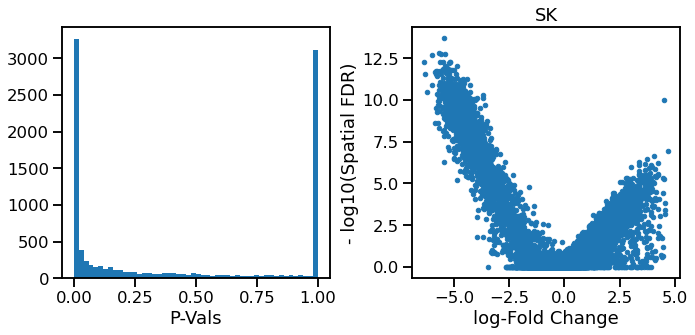

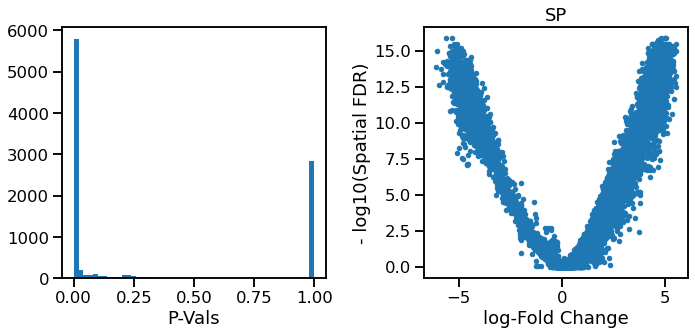

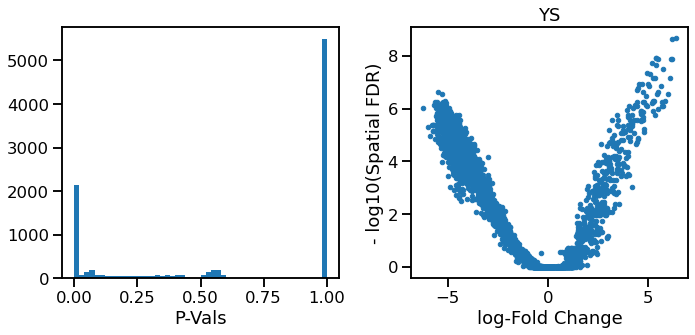

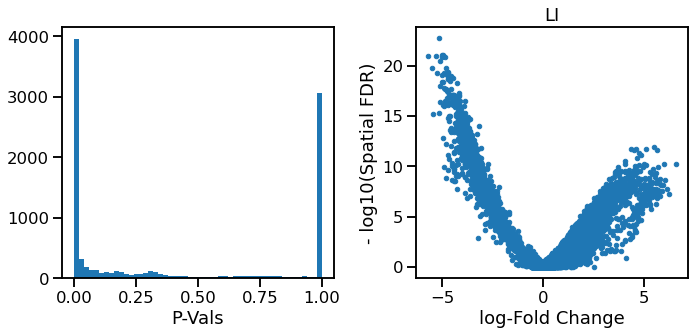

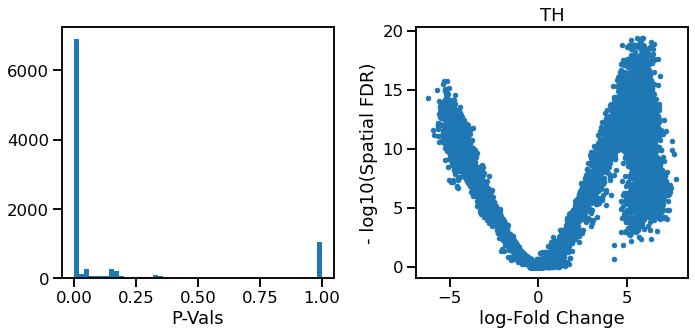

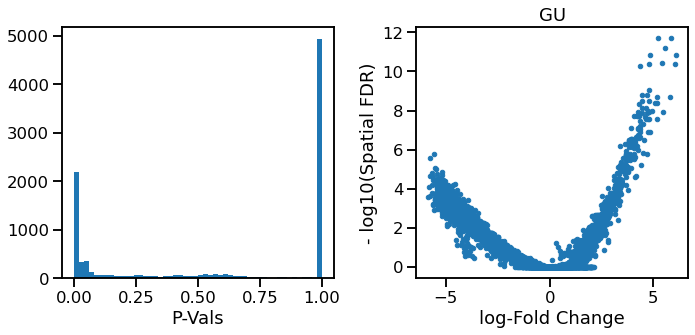

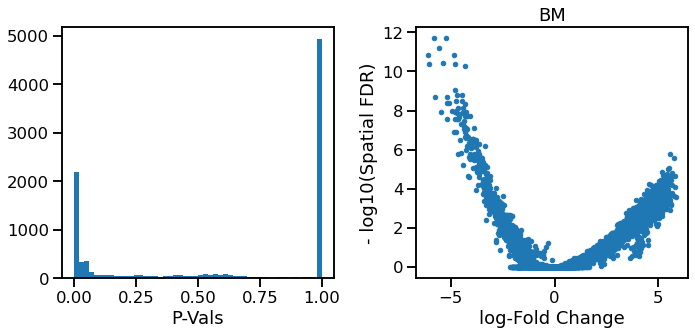

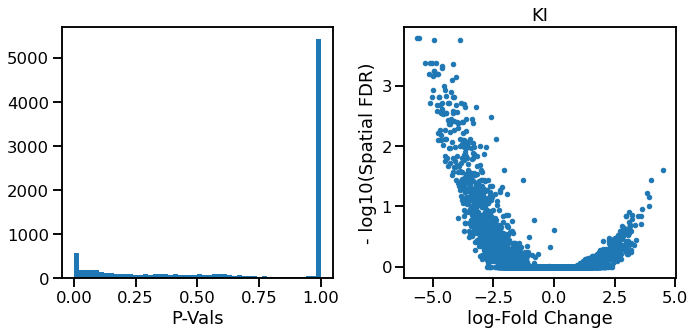

In [73]:
old_figsize = plt.rcParams["figure.figsize"]
for org, milo_res in milo_res_dict.items():
    plt.rcParams["figure.figsize"] = [10,5]
    plt.subplot(1,2,1)
    plt.hist(milo_res.PValue, bins=50);
    plt.xlabel("P-Vals");
    plt.subplot(1,2,2)
    plt.plot(milo_res.logFC, -np.log10(milo_res.SpatialFDR), '.');
    plt.xlabel("log-Fold Change");
    plt.ylabel("- log10(Spatial FDR)");
    plt.title(org);
    plt.tight_layout();
    plt.show()

plt.rcParams["figure.figsize"] = old_figsize

### Plot in embeddings

In [74]:
milopy.utils.build_nhood_graph(adata)

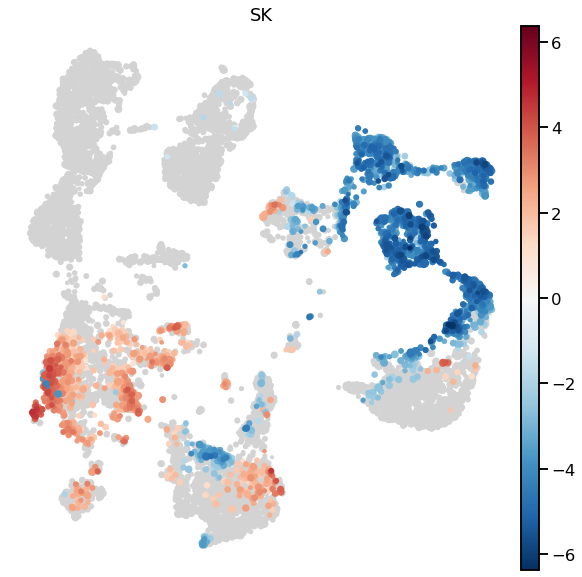

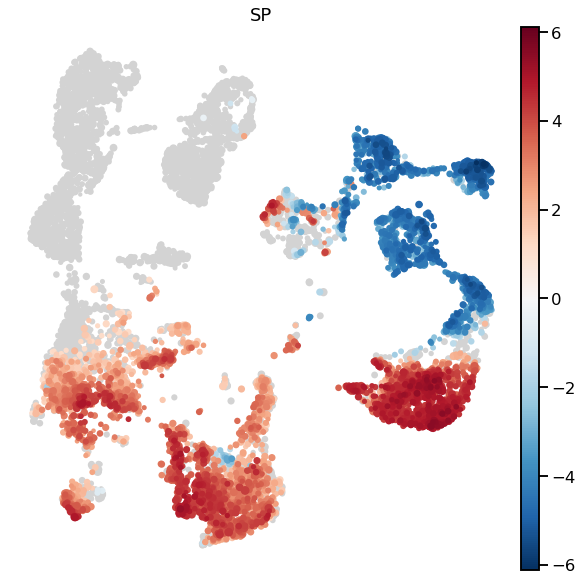

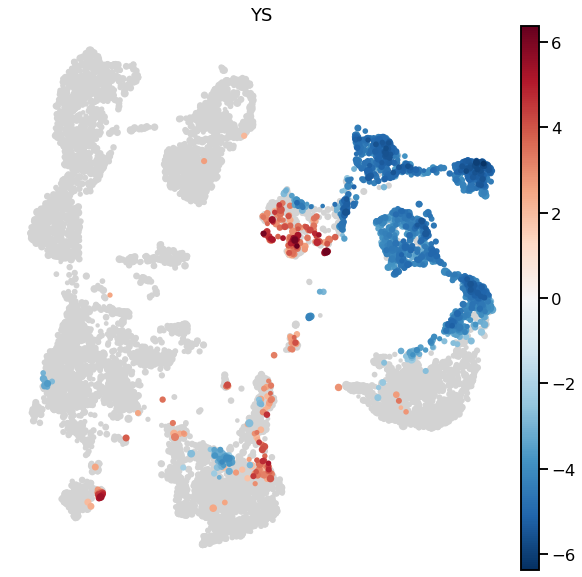

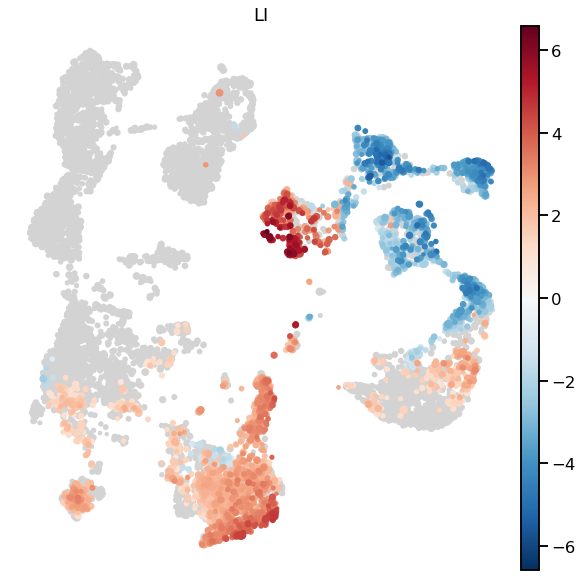

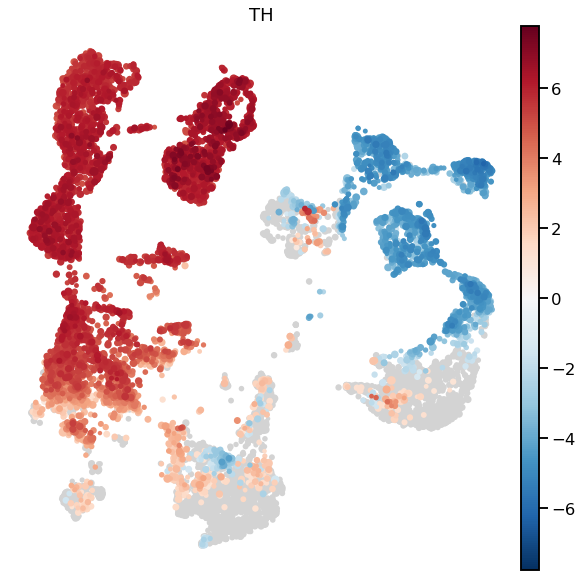

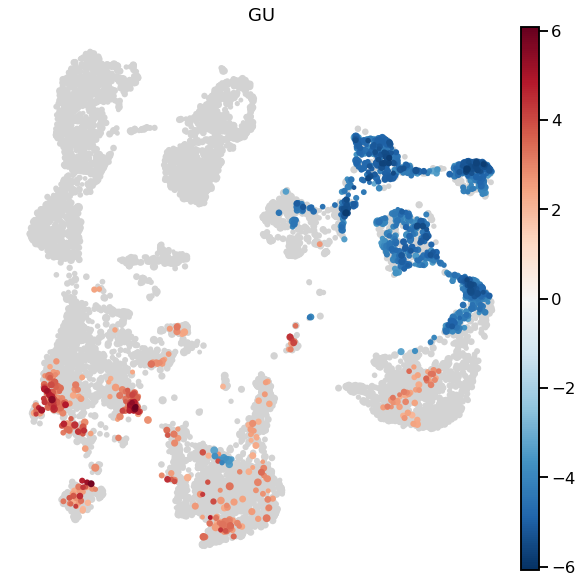

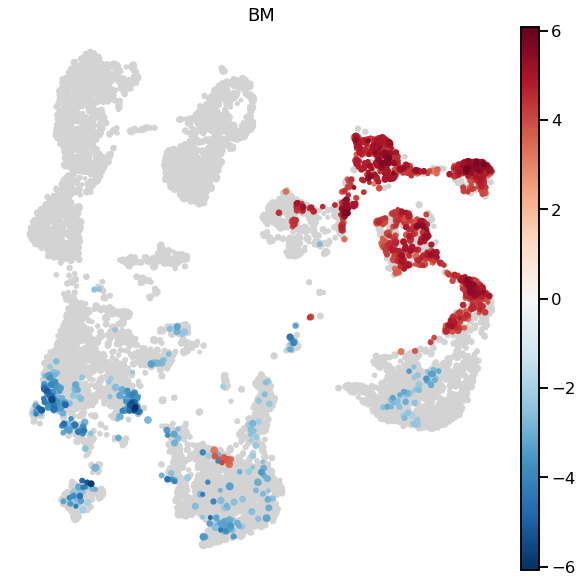

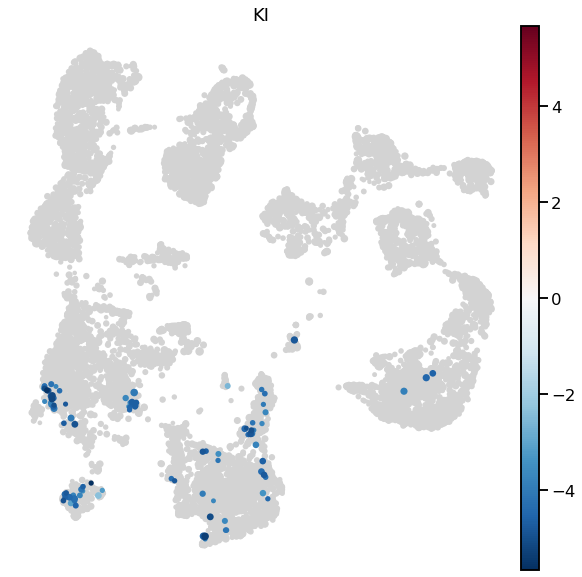

In [75]:
plt.rcParams["figure.figsize"] = [10,10]
milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    milopl.plot_nhood_graph(adata, alpha=0.01, min_size=1, title=org,  save="milo_nhoods_graph_{o}.png".format(o=org))

In [76]:
alpha = 0.01
min_logFC = 2
min_size=0.5
plot_edges = False
title='ciao'

def plot_nhood_graph_enrichment(nhood_adata, alpha = 0.01,
    min_logFC = 2,
    min_size=0.5,
    plot_edges = False,
    title='ciao',**kwargs):
#     nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = nhood_adata.obs["logFC"]
    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan
    nhood_adata.obs["abs_logFC"] = abs(nhood_adata.obs["logFC"])
    nhood_adata.obs.loc[nhood_adata.obs["abs_logFC"] < min_logFC, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] < 0, "graph_color"] = np.nan

    ## Plotting order - extreme logFC on top
    nhood_adata.obs.loc[nhood_adata.obs["graph_color"].isna(), "abs_logFC"] = np.nan
    ordered = nhood_adata.obs.sort_values('abs_logFC', na_position='first').index
    nhood_adata = nhood_adata[ordered]

#     vmax = np.max([nhood_adata.obs["graph_color"].max(), abs(nhood_adata.obs["graph_color"].min())])
    vmin = 0

    sc.pl.embedding(nhood_adata, "X_milo_graph", 
                    color="graph_color", cmap="Reds",
                    size=nhood_adata.obs["Nhood_size"]*min_size, 
                    edges=plot_edges, neighbors_key="nhood",
                    # edge_width = 
                    sort_order=False,
                    frameon=False,
#                     vmax=vmax, 
                    vmin=vmin,
                    title=title,
                    **kwargs
                   )

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


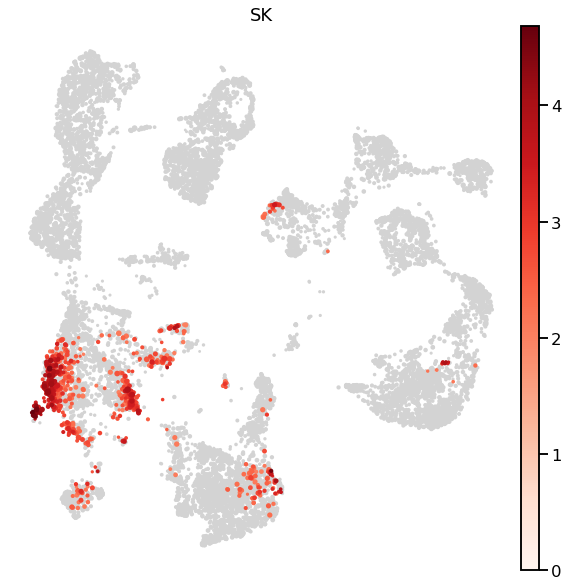

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


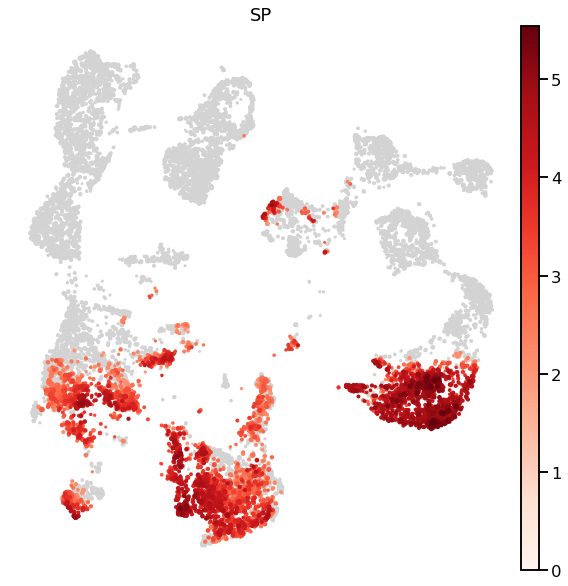

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


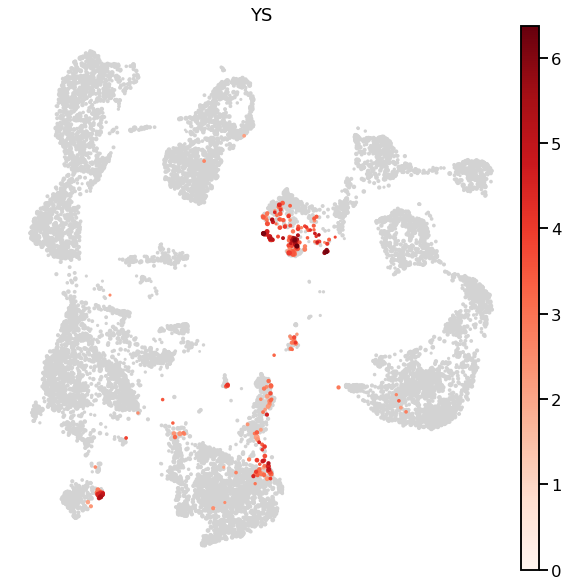

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


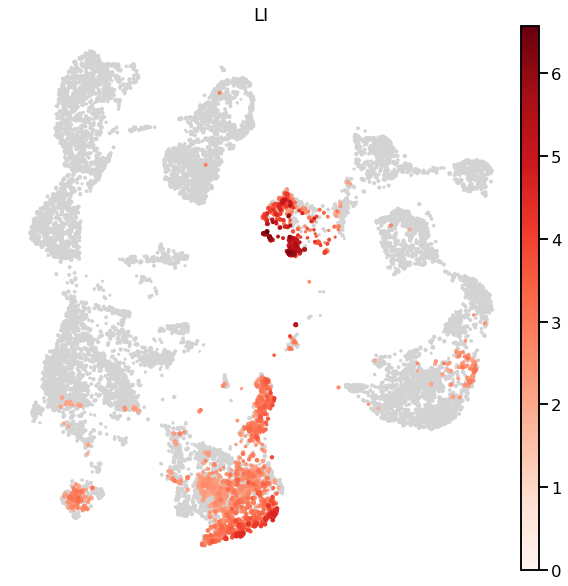

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


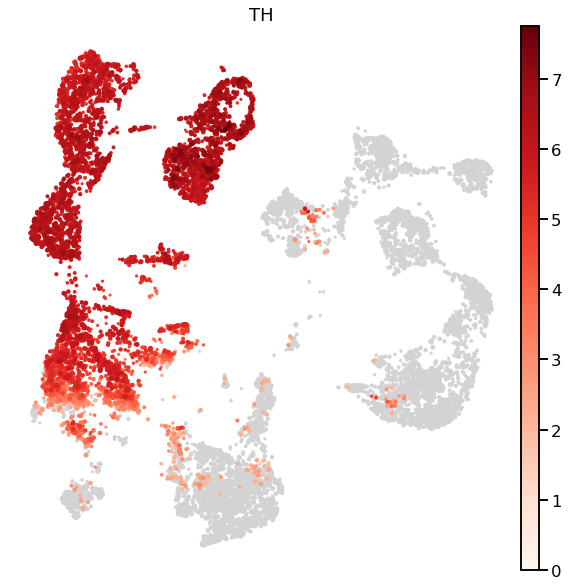

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


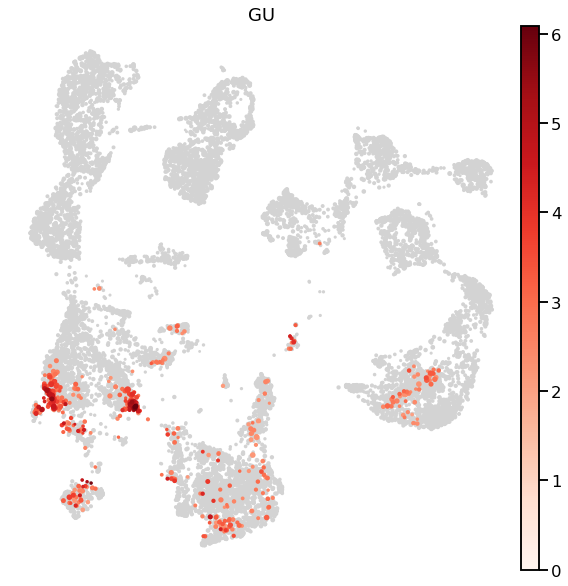

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


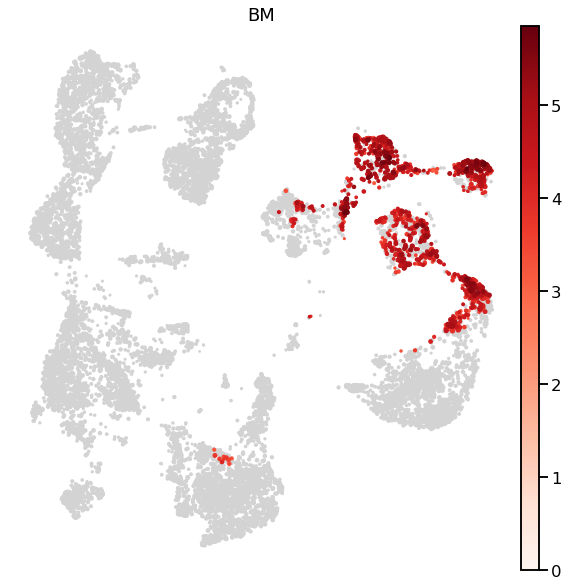

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


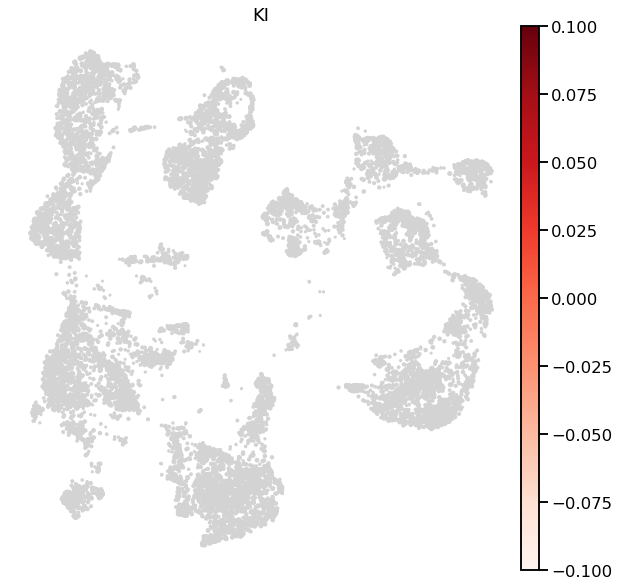

In [77]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")

# milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
    nhood_adata = adata.uns["nhood_adata"].copy()
    plot_nhood_graph_enrichment(nhood_adata, alpha=0.01, min_logFC= 2, min_size=0.5, title=org, 
                                save='nhood_graph_{o}.pdf'.format(o=org))

### Thymic SP T cells figure

... storing 'nhood_annotation' as categorical


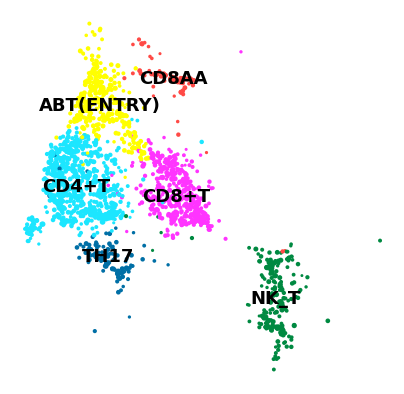

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


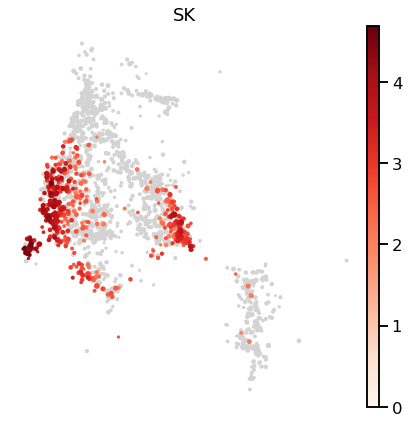

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


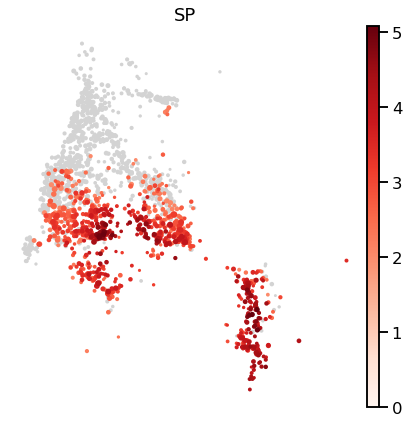

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


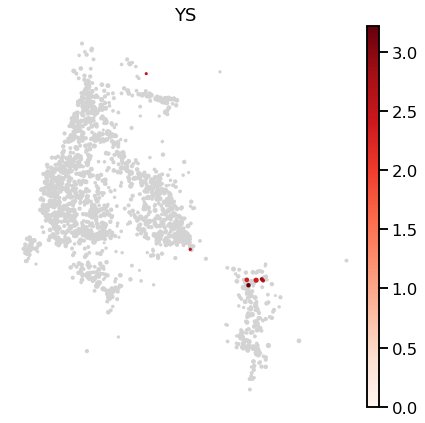

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


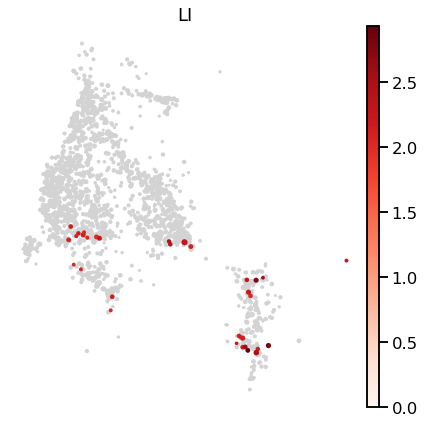

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


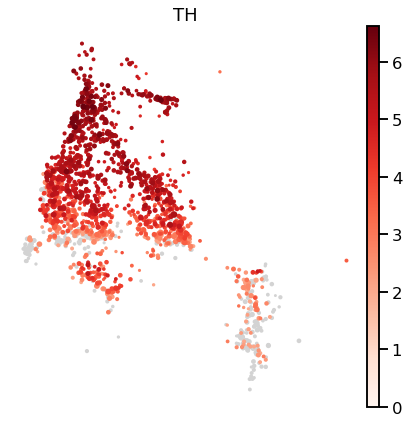

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


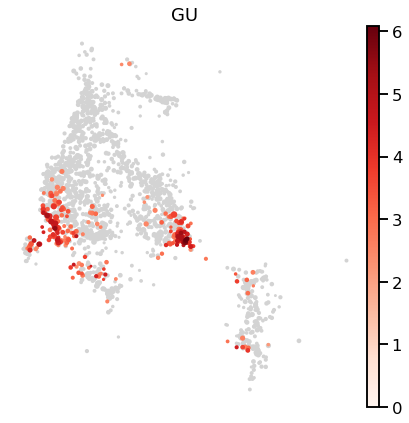

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


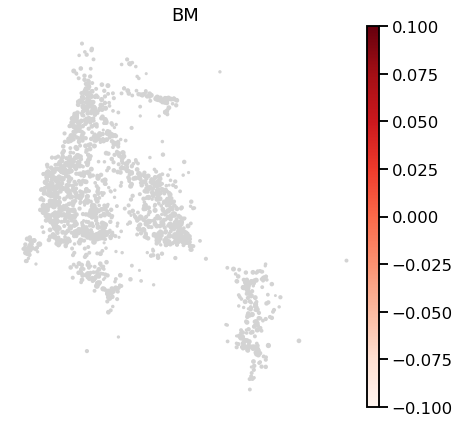

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


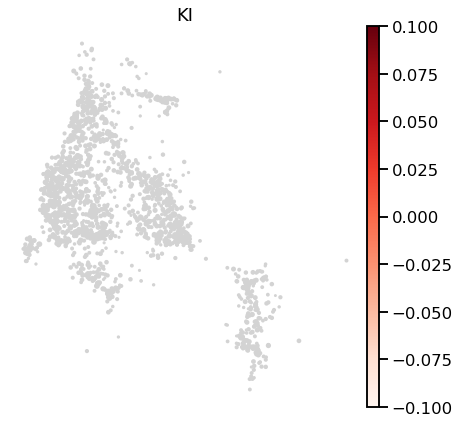

In [56]:
spt_cells = ["CD4+T", "CD8+T", "TH17", "NK_T", "CD8AA", "ABT(ENTRY)"]

plt.rcParams["figure.figsize"] = [7,7]
sns.set_context("talk")
min_size=0.5
nhood_adata = adata.uns["nhood_adata"][adata.uns["nhood_adata"].obs['nhood_annotation'].isin(spt_cells)].copy()
sc.pl.embedding(nhood_adata, "X_milo_graph", 
                color="nhood_annotation",
                size=nhood_adata.obs["Nhood_size"]*min_size, 
                edges=plot_edges, neighbors_key="nhood",
                # edge_width = 
                sort_order=False,
                frameon=False,
                title='',
                legend_loc="on data",
                save='nhood_graph_spt_anno.pdf'
               )


# milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
    nhood_adata = adata.uns["nhood_adata"][adata.uns["nhood_adata"].obs['nhood_annotation'].isin(spt_cells)].copy()
    plot_nhood_graph_enrichment(nhood_adata, alpha=0.01, min_logFC= 2, min_size=0.5, title=org, 
                                save='nhood_graph_spt_{o}.pdf'.format(o=org))

### Visualize with beeswarm plot

In [78]:
%%R -i org_fc_filtered -i org_fdr -h 1000 -w 800

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 
    
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ## Fix some names
    mutate(nhood_anno=ifelse(str_detect(nhood_anno, "NK$"), "NK", nhood_anno)) %>%
    ## Reorder by fold-change 
    group_by(organ, nhood_anno, Nhood) %>%
    mutate(mean_logFC = mean(logFC)) %>%
    ungroup() %>%
    group_by(organ, nhood_anno) %>%
    arrange(- mean_logFC) %>%
    ungroup()  %>%
    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
    group_by(nhood_anno) %>%
    filter(length(unique(Nhood)) > 20) %>%
    ungroup()

unique(plot_df$anno_group)

Joining, by = c("Nhood", "organ")
[1] "T cells"     "Progenitors" "other"       "B cells"     "ILCs"       
[6] "NK cells"   


In [79]:
%%R -w 1200 -h 600 -i figdir -o pl_df
library(ggbeeswarm)
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

anno_group_order <- c('Progenitors', "ILCs", "NK cells","B cells" ,"T cells")

pl_df <- plot_df %>%
    mutate(logFC=ifelse(logFC > 0, logFC, 0)) %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% anno_group_order)

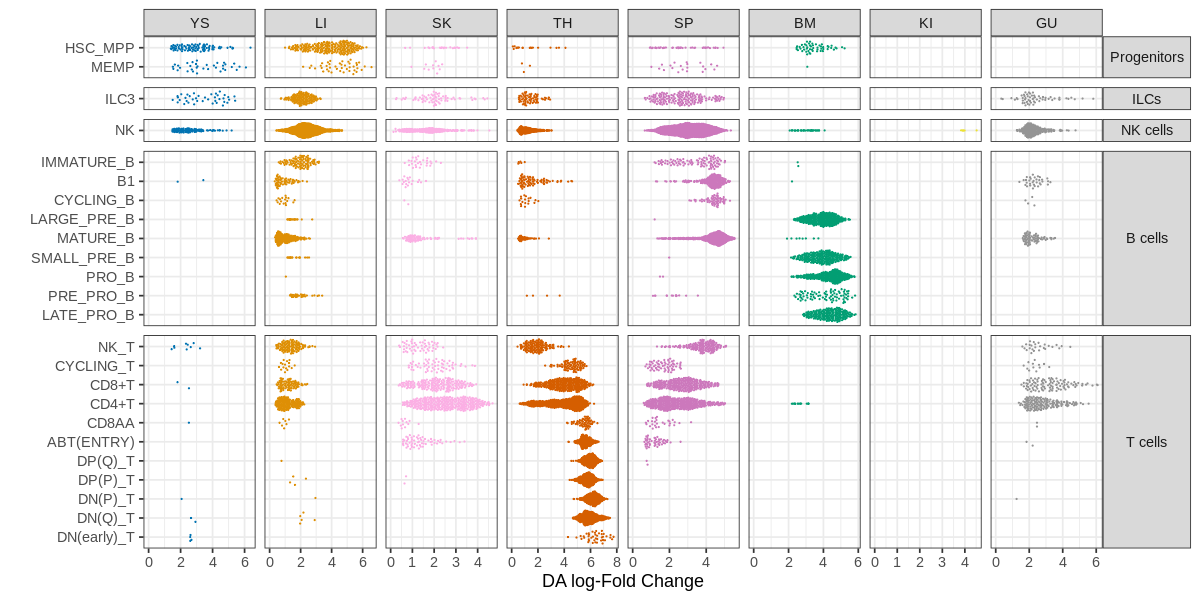

In [80]:
%%R -w 1200 -h 600
alpha=0.1
set.seed(12345)
pl1 <- 
    pl_df %>%
    mutate(organ_color=ifelse((SpatialFDR < alpha) & (logFC > 0), as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
#     geom_quasirandom(size=0.2, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.4, aes(color=organ_color)) +
#     geom_violin(data=. %>% filter(SpatialFDR < alpha), aes(color=organ_color)) +
#     geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
    theme_bw(base_size=18) +
    xlab("") + ylab("DA log-Fold Change") +
    theme(strip.text.y=element_text(angle=0))
    
pl1
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

### Visualize with heatmaps

In [81]:
min_lfc = 2
org_fc_filtered = org_fc.copy()
org_fc_filtered.values[org_fdr.values > 0.1] = 0
org_fc_filtered.values[org_fc_filtered.values < min_lfc] = 0

## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

## Add annotation grouping
anno_group_lymphoid = {
    "NK cells":[x for x in org_fc_filtered.nhood_anno.unique() if x.endswith("NK")],
    "ILCs":[x for x in org_fc_filtered.nhood_anno.unique() if x.startswith("ILC")],
    "B cells":[x for x in org_fc_filtered.nhood_anno.unique() if x.endswith("B") or x=="B1"],
    "T cells":[x for x in org_fc_filtered.nhood_anno.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA"],
   "Progenitors":anno_groups_dict["PROGENITORS"]
    }

anno_group_lymphoid['other'] = [x for x in org_fc_filtered.nhood_anno.unique() if x not in sum(anno_group_lymphoid.values(),[])]
anno_group_lymphoid_rev = {x:g for g,a in anno_group_lymphoid.items() for x in a}

org_fc_filtered['anno_group'] = [anno_group_lymphoid_rev[x] for x in org_fc_filtered['nhood_anno']]

In [63]:
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

org_fc_filtered["hclust_order"] = np.nan
for a in org_fc_filtered.nhood_anno.unique():
    ## Keep high FCs
    
    df = org_fc_filtered[org_fc_filtered.nhood_anno==a].drop(['nhood_anno', 'anno_group', 'hclust_order'], 1)
    clustering = ward(df.values)
    ordered_ixs = org_fc_filtered.index[org_fc_filtered.nhood_anno==a][leaves_list(clustering)]
    org_fc_filtered.loc[ordered_ixs, 'hclust_order'] = np.arange(sum(org_fc_filtered.nhood_anno==a))

In [64]:
# anno_order = [
#     ## Monocytes
#     'PROMONOCYTE', 
#     'MONOCYTE_I_CXCR4',
#     'MONOCYTE_II_IL1B', 
#     'MONOCYTE_III_CCR2',
#     ## MA
# ]

In [65]:
%%R -i org_fc_filtered -w 1000 -h 500

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood, hclust_order), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 


Error in rowid_to_column(., "Nhood") : object 'org_fdr' not found


In [66]:
%%R
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) 

plot_df %>%
arrange(-logFC) %>%
head()
 
    


Error in is.data.frame(y) : object 'long_org_fdr' not found


In [67]:
%%R -w 1200 -h 500
library(ggrastr)
plot_organ_FC_hm_group <- function(plot_df, g, logFC_limits = c(0,7), layout_heights=c(1,4)){
    pl_df <- plot_df %>%
        arrange(nhood_anno, hclust_order) %>%
        mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
        mutate(organ=factor(organ, levels=rev(c("YS", "LI", "BM","TH", "SP", "MLN","SK", "KI", "GU")))) %>%
        mutate(logFC = pmin(logFC, logFC_limits[2])) %>%
        mutate(logFC = pmax(logFC, logFC_limits[1])) 

    p1 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,nhood_anno)) +
        geom_tile_rast(fill='black') +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        theme_classic(base_size=18) +
        remove_x_axis() +
        ylab("") +
        theme(axis.line.x=element_blank(), strip.background=element_blank(), strip.text=element_blank()) +
        ggtitle(g)

    p2 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,organ,  fill=logFC)) +
        geom_tile_rast() +
        facet_grid(.~nhood_anno, scales='free', space="free") +
#       scale_fill_gradient(low='#f7f7f7', high='#b2182b', limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        scale_fill_distiller(palette='Oranges', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        theme_classic(base_size=18) +
        xlab("Neighbourhood") +
        theme(strip.background=element_blank(), strip.text=element_blank(), 
              axis.line.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) 

    (p1 / p2 ) + plot_layout(heights=layout_heights, guides='collect')
    } 
for (g in unique(plot_df$anno_group)){
    plot_organ_FC_hm_group(plot_df, g, layout_heights=c(1,1.5)) + 
    ggsave(paste0(figdir, "enrichment_hm_", g, '.pdf'), width=15, height=7) +
    ggsave(paste0(figdir, "enrichment_hm_", g, '.png'), width=15, height=7)
}

In [68]:
# %%R -w 1200 -h 1200
# pl_ls <- lapply(unique(plot_df$anno_group), function(g) plot_organ_FC_hm_group(plot_df, g, layout_heights=c(1,1.5)))
# wrap_plots(pl_ls[1:3], ncol=1) +
#     plot_layout(guides='collect')

In [69]:
%%R -h 1000 -w 800 -o plot_df
library(ggrastr)
plot_organ_FC_hm_group <- function(plot_df, g, logFC_limits = c(0,7)){

    pl_df <- plot_df %>%
        arrange(nhood_anno, hclust_order) %>%
        mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
        mutate(organ=factor(organ, levels=rev(c("YS", "LI", "BM","TH", "SP", "MLN","SK", "KI", "GU")))) %>%
        mutate(logFC = pmin(logFC, logFC_limits[2])) %>%
        mutate(logFC = pmax(logFC, logFC_limits[1])) 


    pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood, organ,  fill=logFC)) +
        geom_tile_rast() +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        scale_fill_distiller(palette='Oranges', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
#         scale_fill_viridis_c(option='magma', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        theme_classic(base_size=18) +
        xlab("Neighbourhoods") +
        remove_x_axis() +
        theme(strip.background=element_rect(fill='grey', color=NA),
              strip.text.y.left = element_text(angle = 0),
              strip.text.x = element_text(angle = 0)
              ) +
        ggtitle(g)

}

# for (g in unique(plot_df$anno_group)){
#     plot_organ_FC_hm_group(plot_df, g) + 
#     ggsave(paste0(figdir, "enrichment_hm_", g, '_2.pdf'), width=8, height=10) +
#     ggsave(paste0(figdir, "enrichment_hm_", g, '_2.png'), width=8, height=10)
# }

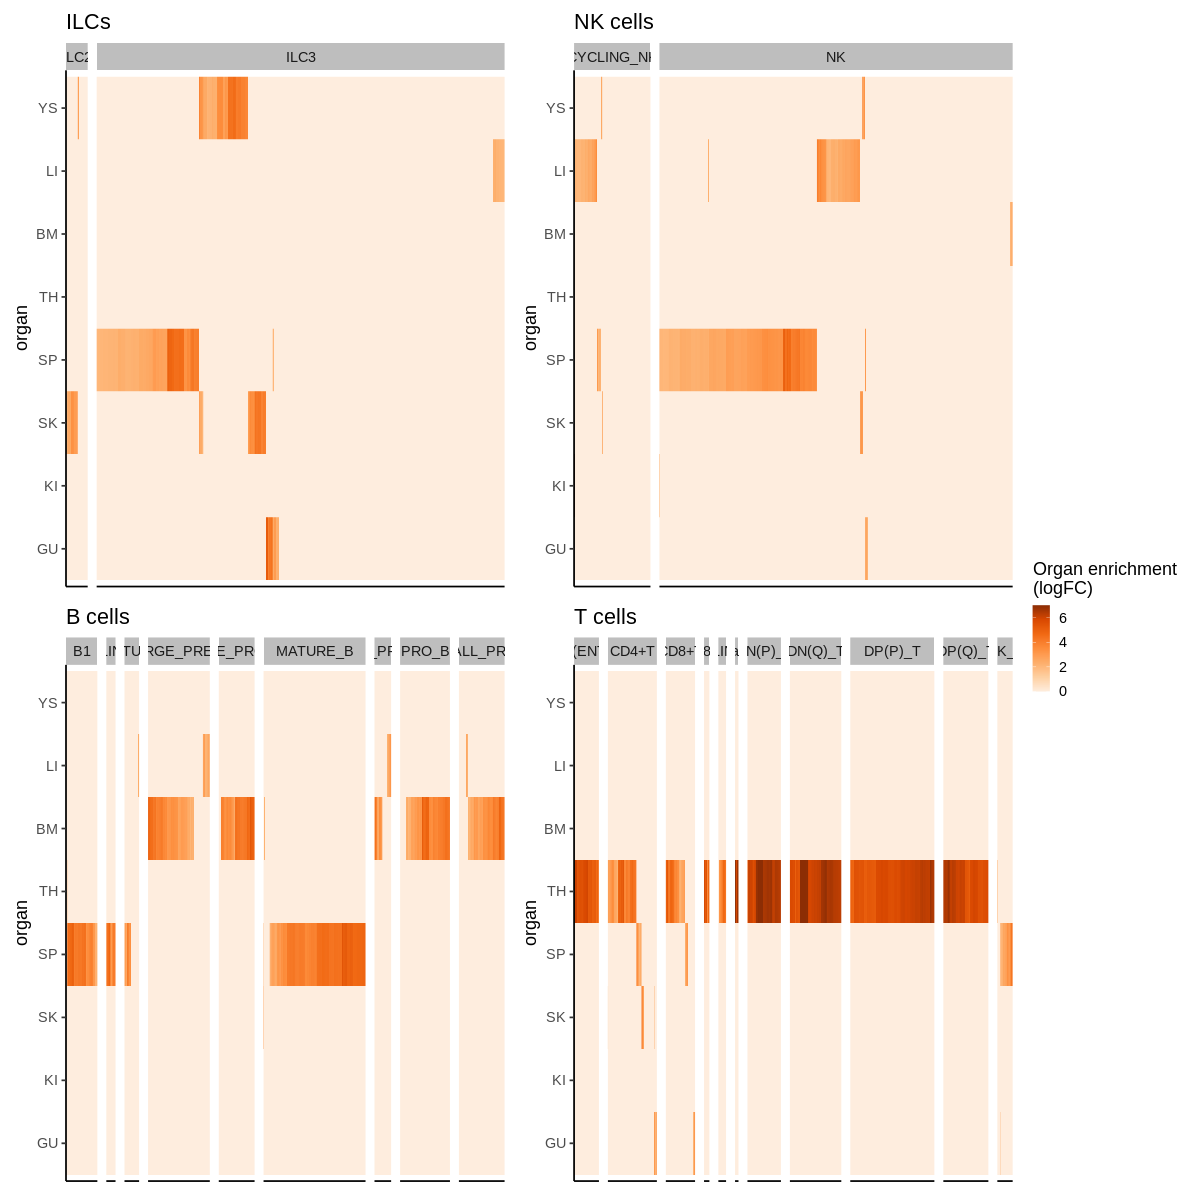

In [75]:
%%R -w 1200 -h 1200
pl_ls <- lapply(c("ILCs", 'NK cells', "B cells", "T cells"), function(g) plot_organ_FC_hm_group(plot_df, g))
wrap_plots(pl_ls, ncol=2, nrow=2) +
    plot_layout(guides='collect') +
    ggsave(paste0(figdir, 'enrichment_hm_all.pdf'), width=20, height=7) +
    ggsave(paste0(figdir, 'enrichment_hm_all.png'), width=20, height=7)

### Save outputs

In [76]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_organ_outs/{s}/'.format(s=split)
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Save dataframe for beeswarm plot
plot_df.to_csv(outdir + "milo_heatmap_plot_data.{s}.csv".format(s=split))

In [77]:
## Save processed anndata object
nhood_adata = adata.uns["nhood_adata"].copy()
del adata.uns["nhood_adata"]
adata.write_h5ad(outdir + "adata4milo_organ.{s}.h5ad".format(s=split))
adata.uns["nhood_adata"] = nhood_adata.copy()

nhood_adata.uns["annotation_labels"] = nhood_adata.uns["annotation_labels"].tolist()
nhood_adata.write_h5ad(outdir + "milo_organ_nhood_adata.{s}.h5ad".format(s=split))

... storing 'nhood_annotation' as categorical


---

### Visualize with beeswarm plot

In [128]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

org_fc_filtered = org_fc.copy()

## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

In [129]:
%%R -i org_fc_filtered -i org_fdr -h 1000 -w 800

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 
    
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ## Fix some names
    mutate(nhood_anno=ifelse(str_detect(nhood_anno, "NK$"), "NK", nhood_anno)) %>%
    ## Reorder by fold-change 
    group_by(organ, nhood_anno, Nhood) %>%
    mutate(mean_logFC = mean(logFC)) %>%
    ungroup() %>%
    group_by(organ, nhood_anno) %>%
    arrange(- mean_logFC) %>%
    ungroup()  %>%
    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
    group_by(nhood_anno) %>%
    filter(length(unique(Nhood)) > 20) %>%
    ungroup()

head(plot_df)

Joining, by = c("Nhood", "organ")
  Nhood nhood_anno anno_group organ     logFC   SpatialFDR mean_logFC
1  2075         NK NK/T CELLS    KI 13.503855 1.895266e-04  13.503855
2  3581         NK NK/T CELLS    KI 13.376124 9.141757e-01  13.376124
3  5327         NK NK/T CELLS    KI 12.763600 5.417663e-02  12.763600
4  2300         NK NK/T CELLS    KI 12.178213 1.247520e-02  12.178213
5  2597    DN(Q)_T NK/T CELLS    TH  7.816306 1.534421e-18   7.816306
6  2527    DN(Q)_T NK/T CELLS    TH  7.755061 1.046417e-18   7.755061


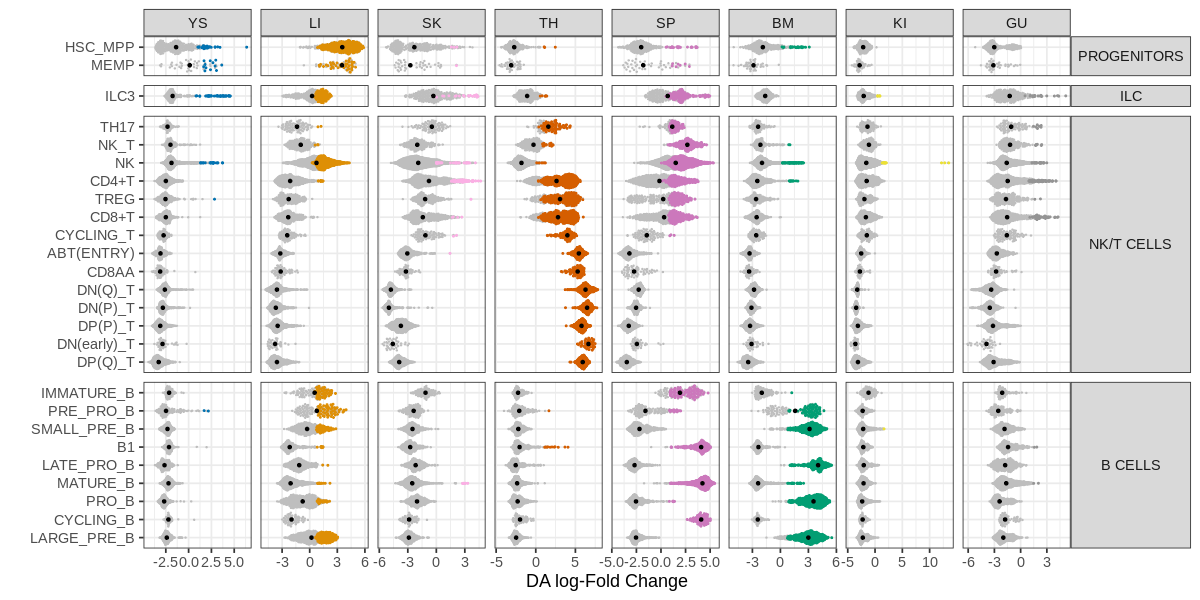

In [130]:
%%R -w 1200 -h 600 -i figdir -o pl_df
library(ggbeeswarm)
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

anno_group_order <- c("PROGENITORS", "ERYTHROID CELLS", "ILC", "MYELOID", "NK/T CELLS", "B CELLS")

pl_df <- plot_df %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% c("PROGENITORS", "NK/T CELLS", "B CELLS", "ILC"))

alpha=0.1
set.seed(12345)
pl1 <- pl_df %>%
    mutate(organ_color=ifelse((SpatialFDR < alpha) & (logFC > 0), as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
    geom_quasirandom(size=0.5, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.7, aes(color=organ_color)) +
    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
#     geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18) +
    xlab("") + ylab("DA log-Fold Change") +
#     scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))
    
pl1 
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

Reorder each anno label by hierarchical clustering

In [137]:
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

org_fc_filtered["hclust_order"] = np.nan
for a in org_fc_filtered.nhood_anno.unique():
    df = org_fc_filtered[org_fc_filtered.nhood_anno==a].drop(['nhood_anno', 'anno_group', 'hclust_order'], 1)
    clustering = ward(df.values)
    ordered_ixs = org_fc_filtered.index[org_fc_filtered.nhood_anno==a][leaves_list(clustering)]
    org_fc_filtered.loc[ordered_ixs, 'hclust_order'] = np.arange(sum(org_fc_filtered.nhood_anno==a))

In [178]:
anno_order = [
## T cells
 'DN(early)_T',
    'DN(Q)_T',
 'DN(P)_T',
 'DP(Q)_T',
    'DP(P)_T',
 'ABT(ENTRY)',
 'CD8+T',
 'CD4+T',
 'CYCLING_T',
'TREG',
'CD8AA',
 'TH17',
 'NK_T',
 'CYCLING_NK',
 'NK',
## B cells
 'PRE_PRO_B',
 'PRO_B',
 'LATE_PRO_B',
 'LARGE_PRE_B',
 'SMALL_PRE_B',
 'IMMATURE_B',
 'MATURE_B',
 'CYCLING_B',
 'B1',
 'PLASMA_B',
## ILCs
'ILC3', 'ILC2', 'CYCLING_ILC',
## Progenitors
'HSC_MPP', 'CMP', 'MEMP'
]



In [179]:
%%R -i org_fc_filtered -i anno_order -w 1000 -h 500

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood, hclust_order), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 

In [180]:
%%R
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    mutate(nhood_anno = factor(nhood_anno, levels=anno_order))

head(plot_df)

Joining, by = c("Nhood", "organ")
  Nhood nhood_anno anno_group hclust_order organ      logFC  SpatialFDR
1     1      CD4+T NK/T CELLS          308    SK  2.9725811 0.047698113
2     1      CD4+T NK/T CELLS          308    SP -0.4949931 0.976743694
3     1      CD4+T NK/T CELLS          308    YS -0.7691522 0.313157797
4     1      CD4+T NK/T CELLS          308    LI -1.2250180 0.005931861
5     1      CD4+T NK/T CELLS          308    TH -0.6588184 0.522455245
6     1      CD4+T NK/T CELLS          308    GU -0.8300197 0.587856799


In [181]:
%%R -w 1500 -h 600
plot_organ_FC_hm_group <- function(plot_df, g, logFC_limits = c(0,7), layout_heights=c(1,4)){
    pl_df <- plot_df %>%
        arrange(nhood_anno, hclust_order) %>%
        mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
        mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
        mutate(logFC = pmin(logFC, logFC_limits[2])) %>%
        mutate(logFC = pmax(logFC, logFC_limits[1])) 

    p1 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,nhood_anno)) +
        geom_tile(fill='black') +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        theme_classic(base_size=18) +
        remove_x_axis() +
        ylab("") +
        theme(axis.line.x=element_blank(), strip.background=element_blank(), strip.text=element_blank()) +
        ggtitle(g)

    p2 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,organ,  fill=logFC)) +
        geom_tile() +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        scale_fill_viridis_c(limits=logFC_limits) +
        theme_classic(base_size=18) +
        xlab("Neighbourhood") +
        theme(strip.background=element_blank(), strip.text=element_blank(), 
              axis.line.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) 

    (p1 / p2 ) + plot_layout(heights=layout_heights, guides='collect')
    } 
    
for (g in unique(plot_df$anno_group)){
    plot_organ_FC_hm_group(plot_df, g, layout_heights=c(2,4)) + 
    ggsave(paste0(figdir, "enrichment_hm_", str_replace(g, "/", "_"), '.pdf'), width=18, height=10) +
    ggsave(paste0(figdir, "enrichment_hm_", str_replace(g, "/", "_"), '.png'), width=18, height=10)
}

In [134]:
li_bm_df = org_fc[['logFC_LI', "logFC_BM"]]
li_bm_df['nhood_annotation'] = adata.uns['nhood_adata'].obs['nhood_annotation']

In [135]:
li_bm_df.nhood_annotation = li_bm_df.nhood_annotation.astype('str')

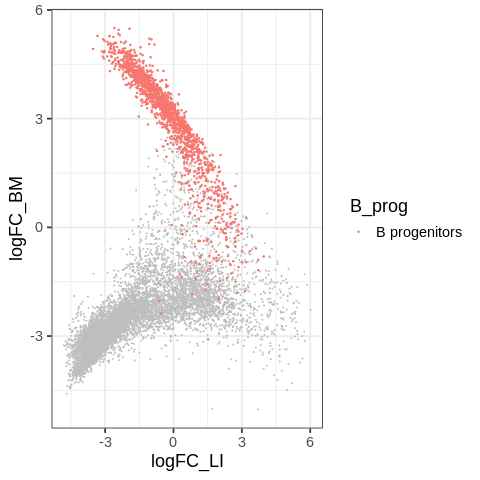

In [136]:
%%R -i li_bm_df
li_bm_df %>%
    rownames_to_column('Nhood') %>%
    mutate(B_prog = ifelse(nhood_annotation %in% c("PRO_B", "LATE_PRO_B", "PRE_PRO_B", 'LARGE_PRE_B', "SMALL_PRE_B"), 'B progenitors', 'NA')) %>%
    ggplot(aes(logFC_LI, logFC_BM, color=B_prog)) +
    geom_point(size=0.3, color='grey') +
    geom_point(data=. %>% filter(B_prog=="B progenitors"), size=0.5) +
    theme_bw(base_size=18)

In [82]:
li_bm_df = org_fc[['logFC_TH', "logFC_SP"]]
li_bm_df['nhood_annotation'] = adata.uns['nhood_adata'].obs['nhood_annotation']

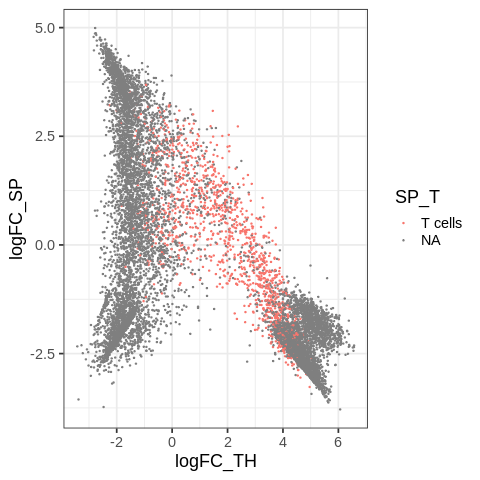

In [86]:
%%R -i li_bm_df
li_bm_df %>%
    mutate(SP_T = ifelse(nhood_annotation %in% c("CD4+T", "CD8+T", "TREG"), 
                           'T cells', NA)) %>%
    ggplot(aes(logFC_TH, logFC_SP, color=SP_T)) +
    geom_point(size=0.5) +
    theme_bw(base_size=18)